In [1]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets
#!pip install perlin_noise
#!pip install numpy
#!pip install matplotlib ipympl jupyter

In [4]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib widget
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise
from scipy.optimize import minimize
from tbcontrol.symbolic import routh
from sympy.solvers import solve

s = ct.tf([1, 0], [1])

In [1]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [2]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.0 #Altura das ondas [m]
Cg = 500 #Momento de restituição do giroscópio [N.m]
Bg = 250.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

# Representação em Espaço de Estados

In [5]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C observando somente o ângulo de roll:
C_φ = sp.Matrix([[1, 0, 0, 0]])

#Matriz D:
D = sp.Matrix([[0]])


In [6]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
En = sp.lambdify((),E)

In [7]:
#Espaço de Estados de malha aberta com Ω = 8000 rpm:
boat_ss = ct.ss(An(8000*np.pi/30),B,C_φ,D)
boat_ss

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

### Função de transferência da planta

In [8]:
G_p0 = ct.tf(boat_ss)

# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][2:], G_p0.den[0][0])
else:
    G_p = G_p0

G_p

TransferFunction(array([-1.84774660e-01,  8.64019967e-12]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

In [9]:
G_p.zeros()

array([4.6760739e-11+0.j])

In [10]:
zeros = G_p.zeros()
poles = G_p.poles()
N = ct.tf(np.poly(zeros),[1])
D = ct.tf(np.poly(poles),[1])
L_0 = N/D
L_0

TransferFunction(array([ 1.0000000e+00, -4.6760739e-11]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

In [11]:
L_0.zeros()

array([4.6760739e-11+0.j])

### Determinação dos ganhos críticos via tabela de Routh

In [12]:
s_s = sp.symbols('s')
N_s = sp.Poly(np.poly(zeros), s_s)
D_s = sp.Poly(np.poly(poles), s_s)
N_s/D_s

(1.0*s - 4.67607389792639e-11)/(1.0*s**4 + 95.2222039835812*s**3 + 1107.89882816501*s**2 + 1182.44144496913*s + 2359.42425472975)

In [13]:
K_c = sp.symbols('K_c')
B_s = K_c * N_s + D_s

table_B = routh(B_s)
table_B

Matrix([
[                                                                                                                                                                    1.0,                            1107.89882816501, 2359.42425472975 - 4.67607389792639e-11*K_c],
[                                                                                                                                                       95.2222039835812,                  1.0*K_c + 1182.44144496913,                                           0],
[                                                                                                                              1095.48112099691 - 0.0105017523031963*K_c, 2359.42425472975 - 4.67607389792639e-11*K_c,                                           0],
[                                                       (0.0105017523031963*K_c**2 - 1083.06341383326*K_c - 1070672.7019803)/(0.0105017523031963*K_c - 1095.48112099691),                                       

In [14]:
sp.solve(table_B[2, 0] > 0, K_c)

(-oo < K_c) & (K_c < 104314.12676373)

In [15]:
sp.solve(table_B[3, 0] > 0, K_c)

((-979.261238120656 < K_c) & (K_c < 104110.946557306)) | ((104314.12676373 < K_c) & (K_c < oo))

# Síntese de um compensador PD via Lugar das Raízes

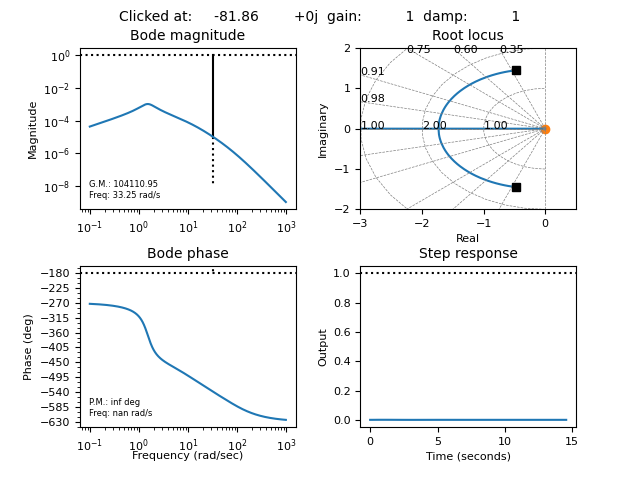

Clicked at     -0.925    +1.276j gain      790.8 damp     0.5869
Clicked at     -0.714    +1.351j gain        452 damp     0.4674
Clicked at    -0.8763    +1.301j gain        713 damp     0.5587
Clicked at    -0.8438    +1.301j gain      670.1 damp     0.5442
Clicked at    -0.8114    +1.375j gain      580.6 damp     0.5081
Clicked at    -0.8114    +1.375j gain      580.6 damp     0.5081
Clicked at    -0.8114    +1.375j gain      580.6 damp     0.5081
Clicked at    -0.8438    +1.375j gain      625.3 damp      0.523
Clicked at    -0.8763    +1.301j gain        713 damp     0.5587
Clicked at    -0.8601    +1.301j gain      691.8 damp     0.5515
Clicked at    -0.8276    +1.326j gain      632.3 damp     0.5295
Clicked at    -0.8114    +1.326j gain      609.8 damp      0.522
Clicked at    -0.7465    +1.351j gain      501.2 damp     0.4837
Clicked at    -0.7789    +1.351j gain      548.7 damp     0.4996
Clicked at    -0.8763    +1.301j gain        713 damp     0.5587
Clicked at    -0.8438    

In [16]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_0, xlim_rlocus=(-3, 0.5), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir do lugar das raízes $L(s)$, pode-se escolher como valor inicial para o ganho proporcional $K_p = 600.0$.

Podemos agora trocar o controlador *proporcional* (P) por um *proporcional-derivativo* (PD), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PD}}(s) = \left( K_p + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & D(s) + K_p N(s) + K_d s N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s N(s)}{D(s) + K_p N(s)}}_{\displaystyle L_5(s)} = 0
\end{align*}

In [17]:
K_p = 600.0

In [18]:
L_5 = (s * N)/(D + K_p * N)
L_5

TransferFunction(array([ 1.0000000e+00, -4.6760739e-11,  0.0000000e+00]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.78244144e+03,
       2.35942425e+03]))

Lugar das raízes de $L_5(s)$ e ajuste de $K_d$

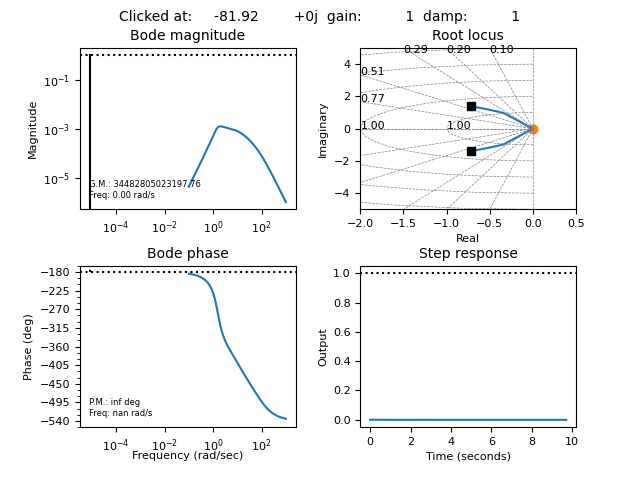

Clicked at    -0.2976   +0.8974j gain       1574 damp     0.3147


In [66]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_5, xlim_rlocus=(-2, 0.5), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa


A partir da análise do lugar das raízes para $L_5(s)$, chega-se a $K_d = 1 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [19]:
K_d = 1.0
T_d = K_d/K_p
T_d

0.0016666666666666668

Finalmente, assumindo os valor calculado para $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PD}}(s) = K_c \left(1 + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 +  K_c \underbrace{\frac{\left(1 + T_d s \right) N(s)}{D(s)}}_{\displaystyle L_6(s)} = 0
\end{align*}

In [20]:
L_6 = ((1 + T_d * s) * N)/D
L_6

TransferFunction(array([ 1.66666667e-03,  1.00000000e+00, -4.67607390e-11]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

Lugar das raízes de $L_6(s)$ e ajuste fino de $K_c$

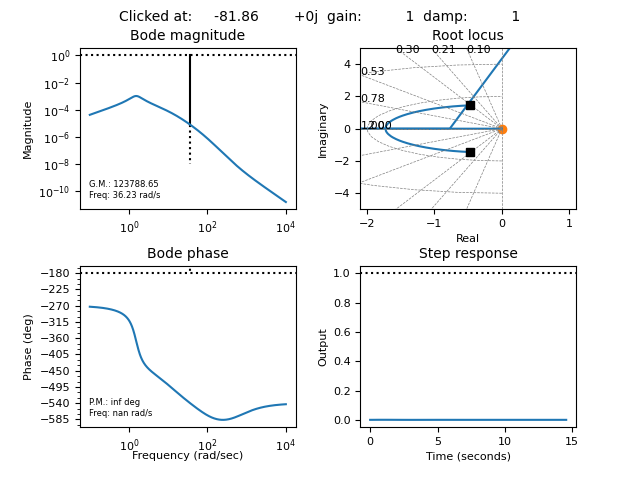

Clicked at     -0.737    +1.331j gain      499.4 damp     0.4844
Clicked at    -0.9596    +1.207j gain        882 damp     0.6222
Clicked at    -0.9596    +1.207j gain        882 damp     0.6222
Clicked at    -0.8112    +1.269j gain      648.3 damp     0.5385
Clicked at    -0.8112    +1.269j gain      648.3 damp     0.5385
Clicked at    -0.7667    +1.455j gain      477.2 damp     0.4661
Clicked at    -0.7667    +1.455j gain      477.2 damp     0.4661


In [21]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_6, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c$ = 600, tem-se o seguinte compensador PD:

In [22]:
K_c_PD = 600.0
N_d = 1000

G_c_PD = K_c_PD * (1 + (T_d * s)/(1 + T_d * s/N_d))
G_c_PD

TransferFunction(array([  1001., 600000.]), array([1.66666667e-03, 1.00000000e+03]))

Diagrama de Bode do compensador PD sintetizado

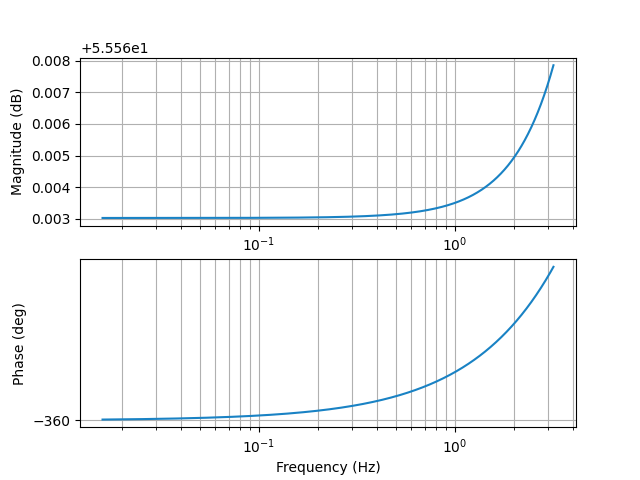

In [23]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PD,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['blue'],
                                   dB=True, Hz=True)

# Síntese de Compensadores PI e PID via Lugar das Raízes

Tomaremos o mesmo valor inicial presumido de $K_p$ = 600.0

In [24]:
K_p = 600.0
L_1 = N/(s * (D + K_p * N))
L_1

TransferFunction(array([ 1.0000000e+00, -4.6760739e-11]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.61244144e+03,
       2.35942425e+03, 0.00000000e+00]))

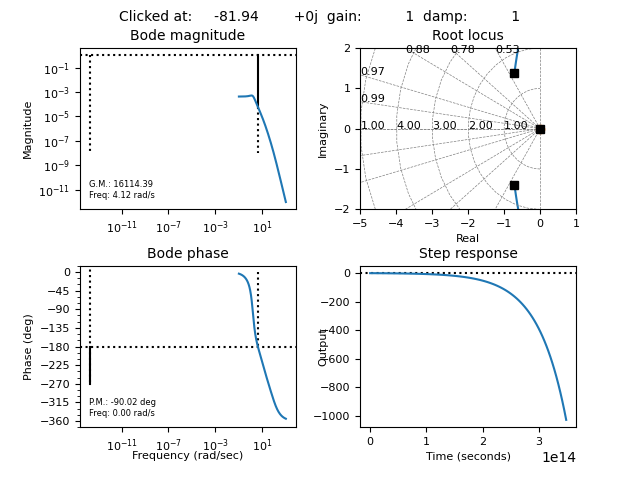

Clicked at    -0.6638    -1.674j gain      822.4 damp     0.3687
Clicked at    -0.6916    -1.475j gain      240.3 damp     0.4244
Clicked at    -0.6916    -1.475j gain      240.3 damp     0.4244


In [25]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_1, xlim_rlocus=(-5, 1), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_1(s)$, chega-se a $K_i = 3.0 \ \text{s}^{-1}$ como escolha razoável para o ganho integral.

Assim pode-se calcular $T_i$ pela expressão:
$$T_i = \frac{K_p}{K_i}$$

In [26]:
K_i = 1.0
T_i = K_p/K_i
T_i

430.0

Assumindo os valor calculados para $T_i$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PI}}(s) = K_c \left(1 + \frac{1}{T_i s}\right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PI}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s)N(s)}{s T_i D(s)}}_{\displaystyle L_2(s)} = 0
\end{align*}

In [27]:
L_2 = (1 + T_i * s) * N/(s * T_i * D)
L_2

TransferFunction(array([ 4.3000000e+02,  9.9999998e-01, -4.6760739e-11]), array([4.30000000e+02, 4.09455477e+04, 4.76396496e+05, 5.08449821e+05,
       1.01455243e+06, 0.00000000e+00]))

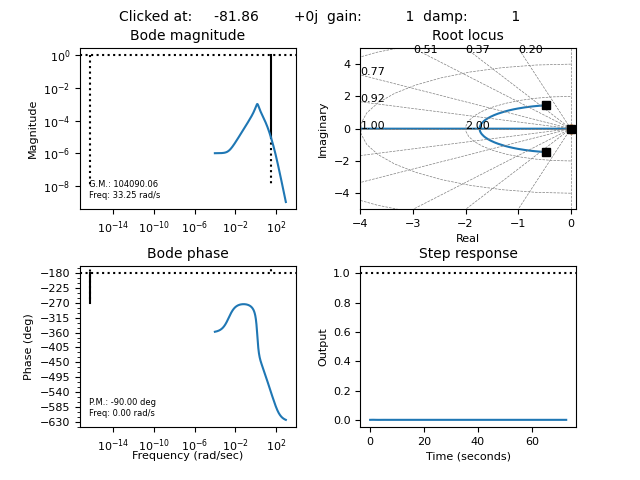

Clicked at    -0.8468    +1.269j gain        696 damp      0.555
Clicked at    -0.6947    +1.517j gain      345.1 damp     0.4163
Clicked at    -0.6947    +1.517j gain      345.1 damp     0.4163
Clicked at    -0.7708    +1.455j gain      483.2 damp     0.4681
Clicked at    -0.7708    +1.455j gain      483.2 damp     0.4681
Clicked at    -0.8468    +1.331j gain      655.4 damp     0.5367
Clicked at    -0.8468    +1.331j gain      655.4 damp     0.5367


In [28]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_2, xlim_rlocus=(-4, 0.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Obtém-se assim $K_c = 600$, o que leva o seguinte compensador PI:

In [29]:
K_c_PI = 600

G_c_PI = K_c_PI * (1 + 1/(T_i * s))
G_c_PI

TransferFunction(array([258000.,    600.]), array([430.,   0.]))

Diagrama de Bode do compensador PI sintetizado

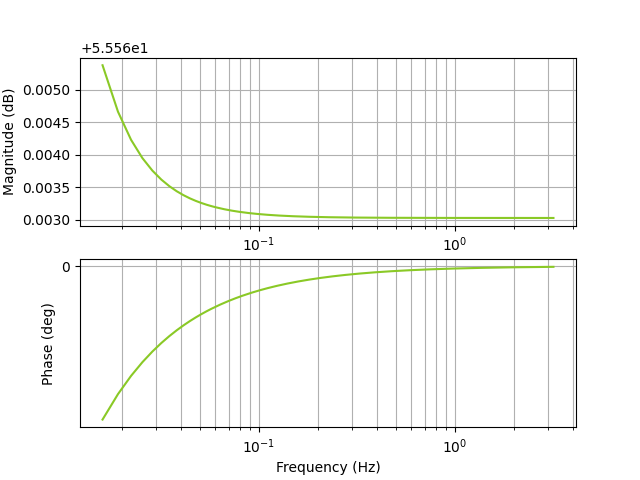

In [30]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PI,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['green'],
                                   dB=True, Hz=True)

#### 3.3. Síntese de um compensador PID

Podemos agora trocar o controlador *proporcional-integral* (PI) por um *proporcional-integral-derivativo* (PID), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PID}}(s) = \left( K_p + \frac{K_i}{s} + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + K_i \frac{N(s)}{s D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & s D(s) + (K_p s + K_i)N(s) + K_d s^2 N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s^2 N(s)}{s D(s) + (K_p s + K_i)N(s)}}_{\displaystyle L_3(s)} = 0
\end{align*}

In [31]:
L_3 = (s * s * N)/(s * D + (K_p * s + K_i) * N)
L_3

TransferFunction(array([ 1.0000000e+00, -4.6760739e-11,  0.0000000e+00,  0.0000000e+00]), array([ 1.00000000e+00,  9.52222040e+01,  1.10789883e+03,  1.61244144e+03,
        2.36042425e+03, -4.67607390e-11]))

Lugar das raízes de $L_3(s)$ e ajuste de $K_d$

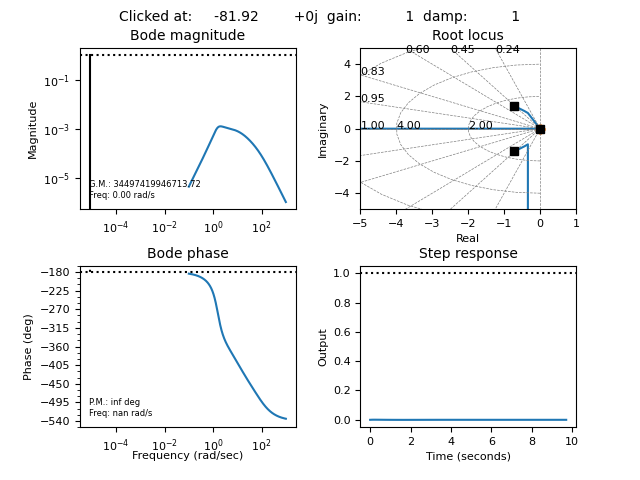

Clicked at    -0.1352   +0.7115j gain       3507 damp     0.1866


In [32]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_3, xlim_rlocus=(-5, 1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_3(s)$, chega-se a $K_d = 1 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [33]:
K_d = 1.0
T_d = K_d/K_p
T_d

0.002325581395348837

Finalmente, assumindo os valores calculados para $T_i$ e $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PID}}(s) = K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s + T_d T_i s^2)N(s)}{s T_i D(s)}}_{\displaystyle L_4(s)} = 0
\end{align*}


In [34]:
L_4 = ((1 + T_i * s + T_d * T_i * s * s) * N)/(s * T_i * D)
L_4

TransferFunction(array([ 1.0000000e+00,  4.3000000e+02,  9.9999998e-01, -4.6760739e-11]), array([4.30000000e+02, 4.09455477e+04, 4.76396496e+05, 5.08449821e+05,
       1.01455243e+06, 0.00000000e+00]))

Lugar das raízes de $L_4(s)$ e ajuste fino de $K_c$

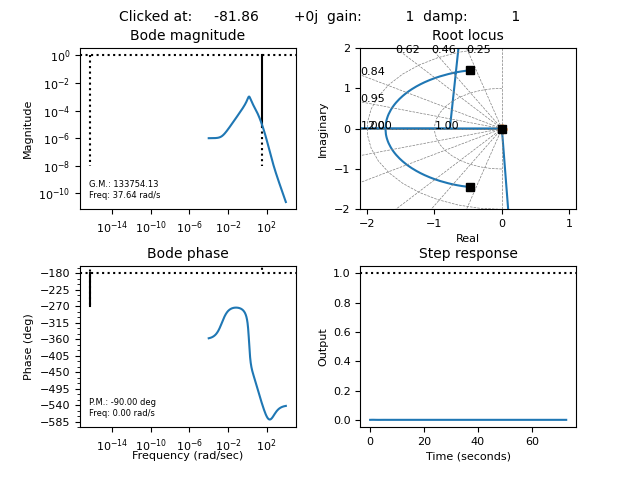

Clicked at    -0.7519    +1.375j gain      496.3 damp     0.4797
Clicked at    -0.7519    +1.375j gain      496.3 damp     0.4797
Clicked at    -0.8409    +1.351j gain      637.1 damp     0.5286
Clicked at    -0.8409    +1.351j gain      637.1 damp     0.5286


In [35]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_4, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c = 600$, tem-se o seguinte compensador PID:

In [36]:
K_c_PID = 600.0
N_d = 1000

G_c_PID = K_c_PID * (1 + 1/(T_i * s) + (T_d * s)/(1 + T_d * s/N_d))
G_c_PID

TransferFunction(array([6.00600000e+05, 2.58000001e+08, 6.00000000e+05]), array([1.0e+00, 4.3e+05, 0.0e+00]))

Diagrama de Bode do compensador PID sintetizado

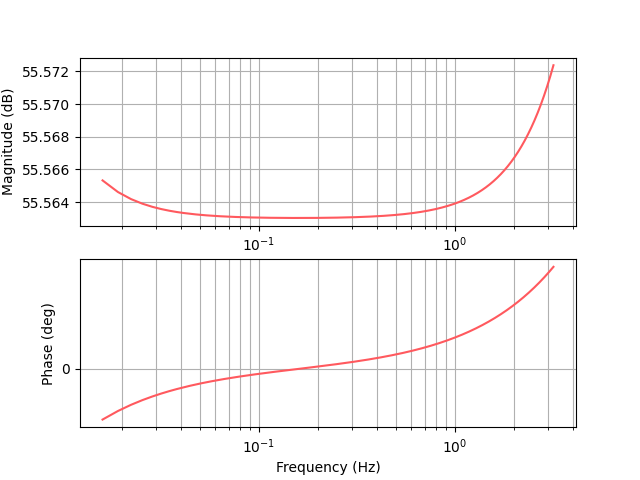

In [37]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PID,
                                omega=np.linspace(0.1, 20, 1001),
                                color=cp['red'],
                                dB=True, Hz=True)

### Análise das respostas em malha fechada com compensadores PI, PD e PID

#### Função de transferência entre referência (r) e saída (c)

In [63]:
rc_tf_PI = ct.feedback(G_c_PI * L_0)
rc_tf_PD = ct.feedback(G_c_PD * L_0)
rc_tf_PID = ct.feedback(G_c_PID * L_0)
rc_tf_PID

TransferFunction(array([ 6.00600000e+05,  2.58000001e+08,  5.99999988e+05, -2.80564434e-05]), array([ 1.00000000e+00,  4.30095222e+05,  4.09466556e+07,  4.76998279e+08,
        7.66452182e+08,  1.01515243e+09, -2.80564434e-05]))

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_7316\2475582075.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


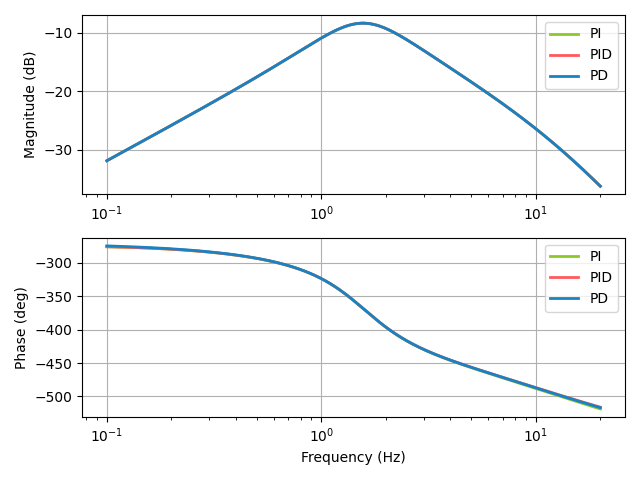

In [64]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    rc_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    rc_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    rc_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Função de transferência entre referência (r) e entrada de controle (u)

In [65]:
ru_tf_PI = (1/0.1848)*ct.feedback(G_c_PI, L_0)
ru_tf_PD = (1/0.1848)*ct.feedback(G_c_PD, L_0)
ru_tf_PID = (1/0.1848)*ct.feedback(G_c_PID, L_0)
ru_tf_PID

TransferFunction(array([3.25000000e+06, 1.70557607e+09, 1.36544009e+11, 1.55089398e+12,
       1.66207632e+12, 3.29784051e+12, 7.66046836e+09]), array([ 1.00000000e+00,  4.30095222e+05,  4.09466556e+07,  4.76998279e+08,
        7.66452182e+08,  1.01515243e+09, -2.80564434e-05]))

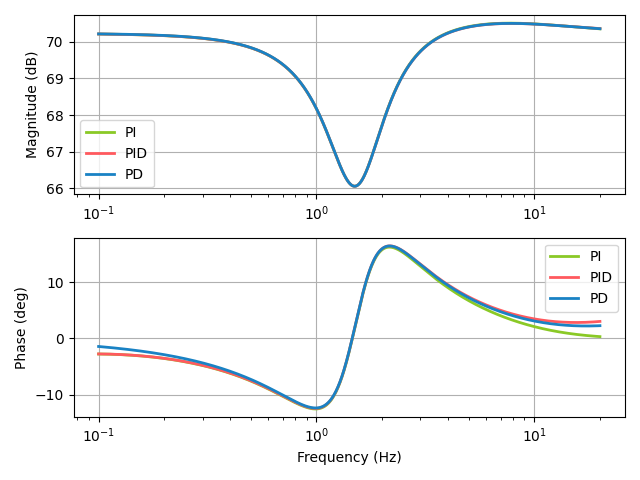

In [66]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    ru_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    ru_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    ru_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Resposta a degrau

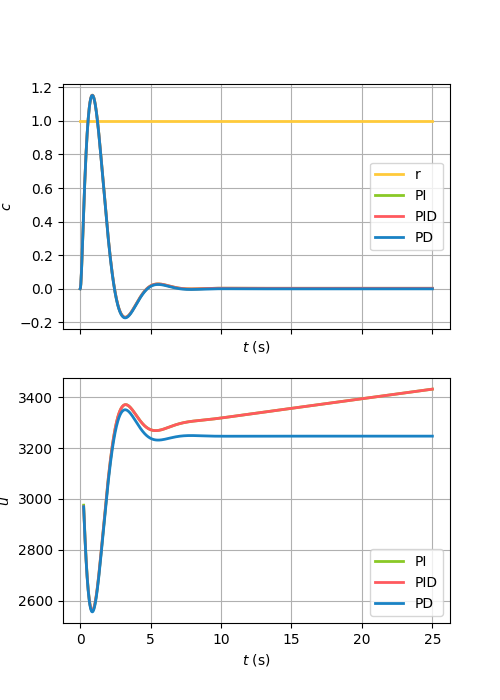

In [56]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

t, y_PI = ct.step_response(rc_tf_PI, ts)
t, u_PI = ct.step_response(ru_tf_PI, ts)

t, y_PID = ct.step_response(rc_tf_PID, ts)
t, u_PID = ct.step_response(ru_tf_PID, ts)

t, y_PD = ct.step_response(rc_tf_PD, ts)
t, u_PD = ct.step_response(ru_tf_PD, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, np.ones(len(t)), color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'], 
                    label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

#### Resposta a rampa

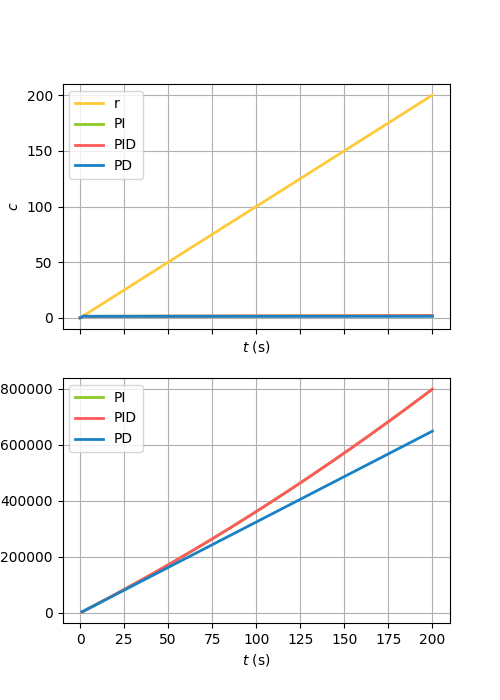

In [57]:
# simulação do sistema em MF
ts = np.linspace(0, 200, 2000)

t, y_PI = ct.forced_response(rc_tf_PI, ts, U=ts)
t, u_PI = ct.forced_response(ru_tf_PI, ts, U=ts)

t, y_PID = ct.forced_response(rc_tf_PID, ts, U=ts)
t, u_PID = ct.forced_response(ru_tf_PID, ts, U=ts)

t, y_PD = ct.forced_response(rc_tf_PD, ts, U=ts)
t, u_PD = ct.forced_response(ru_tf_PD, ts, U=ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'],
                   label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

In [59]:
p_tf_PI = (1/0.1848)*ct.series(G_c_PI, L_0)
p_tf_PD = (1/0.1848)*ct.series(G_c_PD, L_0)
p_tf_PID = (1/0.1848)*ct.series(G_c_PID, L_0)
p_tf_PID

TransferFunction(array([ 3.25000000e+06,  1.39610390e+09,  3.24675318e+06, -1.51820581e-04]), array([1.00000000e+00, 4.30095222e+05, 4.09466556e+07, 4.76397679e+08,
       5.08452181e+08, 1.01455243e+09, 0.00000000e+00]))

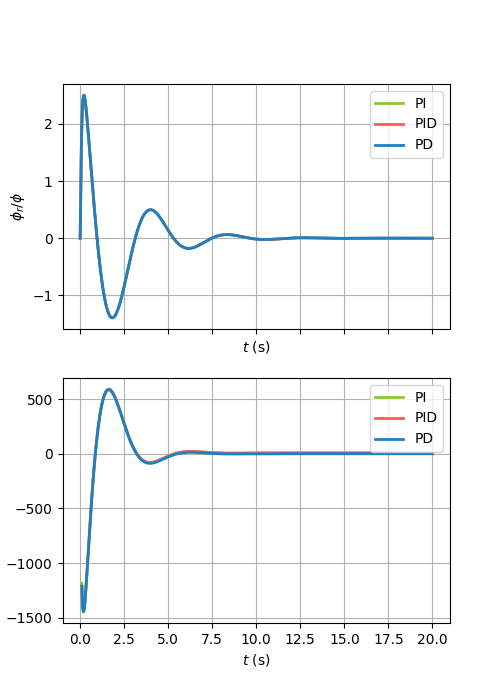

: 

In [72]:
# simulação do sistema em MF
ts = np.linspace(0, 20, 2000)
x0 = 0.01

t, y_PI = ct.impulse_response(p_tf_PI, T=ts)
t, u_PI = ct.impulse_response(ru_tf_PI, T=ts)

t, y_PID = ct.impulse_response(p_tf_PID, T=ts)
t, u_PID = ct.impulse_response(ru_tf_PID, T=ts)

t, y_PD = ct.impulse_response(p_tf_PD, T=ts)
t, u_PD = ct.impulse_response(ru_tf_PD, T=ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

#state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$\phi_r/\phi$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'],
                   label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u (N.m)$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()